# Typical MNIST Implementation

In [2]:
from fastcore.all import *
from fastai.data.all import *
from fastai.vision.all import *
from PIL import Image

path = Path("./mnist_sample/train")
threes = (path/'3').ls().sorted()
sevens = (path/'7').ls().sorted()
im3 = Image.open(threes[1])
im3

In [3]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [4]:
from pandas import DataFrame

im3_t = tensor(im3)
df = DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [5]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

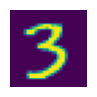

In [6]:
show_image(tensor(three_tensors[1]))

In [7]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

.stack takes in a list of tensors and combines them into a single tensor (in this case) with 6131 items, and a 28 x 28 array of values for each pixel. The division by 255 is because generally you want values between 0 and 1 and 255 is the max value (making 255 / 255 = 1)

mean3 = mean of all pixels within 3s training data

<AxesSubplot:>

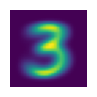

In [8]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

mean7 = mean of all pixels within 7s training data

<AxesSubplot:>

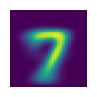

In [9]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [10]:
a_3 = stacked_threes[1]

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [11]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7) ** 2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [12]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [13]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path.parent/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path.parent/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

.mean((-1,-2)) is to take the mean of the last element (-1) and second-to-last element (-2) or in this case, the pixel values

In [14]:
def mnist_distance(a,b) : return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [15]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

We're able to run the mnist_distance on a tensor with many images because in the end it's just matrix multiplication

In [16]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

In the following we show how in a 3 x 1 x 1 (imagine 3 single pixel values) can have a single value (5) removed from them to turn 3 values of 10, 15, 20 into 5, 10, 15

In [17]:
full = tensor([[[10]], [[15]], [[20]]])
sub = tensor([[5]])
diff = full - sub

full.shape,sub.shape,diff.shape, diff

(torch.Size([3, 1, 1]),
 torch.Size([1, 1]),
 torch.Size([3, 1, 1]),
 tensor([[[ 5]],
 
         [[10]],
 
         [[15]]]))

We can make a test now checking if the distance is less for a 3 then it's a 3

In [18]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x, mean7)

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Can check all 3s

In [19]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [20]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [21]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [22]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [23]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [25]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))
weights

tensor([[ 1.7569e-01],
        [-2.9751e-01],
        [ 1.0439e+00],
        [-9.7557e-01],
        [-3.7370e-01],
        [-8.6504e-01],
        [-5.3123e-01],
        [-8.8697e-02],
        [ 4.0133e-01],
        [ 8.9362e-01],
        [ 1.5387e+00],
        [ 1.1125e+00],
        [ 3.3762e-01],
        [ 8.0295e-01],
        [-7.5261e-02],
        [ 5.9797e-01],
        [ 4.6176e-01],
        [ 1.4626e-01],
        [ 2.6454e-01],
        [ 9.1106e-01],
        [-2.9753e-01],
        [-1.6315e+00],
        [-3.9199e-01],
        [-4.5618e-01],
        [ 2.3560e+00],
        [-7.2045e-01],
        [ 1.6028e+00],
        [ 9.3995e-01],
        [-1.7200e-01],
        [-6.1906e-01],
        [-1.0928e+00],
        [ 1.8990e-02],
        [ 1.0396e-01],
        [-2.3245e+00],
        [ 3.3190e-01],
        [-1.0236e+00],
        [ 3.0728e-02],
        [-1.3003e+00],
        [ 7.8492e-01],
        [ 6.4617e-01],
        [-7.6329e-01],
        [ 6.8238e-02],
        [-7.1792e-01],
        [-2

In [26]:
bias = init_params(1); bias

tensor([-1.6935], requires_grad=True)

In [27]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[12.3307],
        [19.3054],
        [ 9.9163],
        ...,
        [ 7.9158],
        [-5.7089],
        [16.6841]], grad_fn=<AddBackward0>)

In [28]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [ True],
        [False]])

In [29]:
corrects.float().mean().item()

0.594304621219635

In [31]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [32]:
weights = init_params((28*28*1))
bias = init_params(1)

dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [33]:
valid_dl = DataLoader(valid_dset, batch_size=256)
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [34]:
preds = linear1(batch)
preds

tensor([-0.8335, 11.2768, -2.3899,  0.5064], grad_fn=<AddBackward0>)

In [35]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4973, grad_fn=<MeanBackward0>)

In [36]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784]), tensor(-0.0206), tensor([-0.1307]))

In [37]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0412), tensor([-0.2614]))

In [40]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [41]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.4903

In [42]:
lr = 1
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7135

In [43]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8255 0.8919 0.9173 0.9288 0.9384 0.9425 0.9448 0.9475 0.9499 0.9518 0.9532 0.9551 0.9561 0.9556 0.9556 0.9576 0.9576 0.9581 0.9591 0.96 

In [44]:
linear_model = nn.Linear(28*28,1)
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [45]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

opt = BasicOptim(linear_model.parameters(), lr)

def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

validate_epoch(linear_model)
        

0.273

In [46]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

train_model(linear_model, 20)

0.4932 0.8677 0.8203 0.9102 0.9341 0.9463 0.9555 0.9624 0.9653 0.9668 0.9692 0.9712 0.9726 0.9746 0.9761 0.9765 0.9775 0.9775 0.9785 0.979 

In [49]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637156,0.503608,0.495584,00:00
1,0.584681,0.129718,0.911678,00:00
2,0.211844,0.214232,0.799313,00:00
3,0.091433,0.116216,0.903827,00:00
4,0.047124,0.082563,0.930324,00:00
5,0.029938,0.065275,0.945044,00:00
6,0.022934,0.054678,0.954367,00:00
7,0.019874,0.047678,0.961236,00:00
8,0.018363,0.042798,0.965162,00:00
9,0.017480,0.039225,0.966634,00:00


In [50]:
simple_net = nn.Sequential(nn.Linear(28*28, 30), nn.ReLU(), nn.Linear(30,1))
learner = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learner.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.286995,0.412445,0.504907,00:00
1,0.136728,0.219076,0.816977,00:00
2,0.077330,0.112417,0.920020,00:00
3,0.051864,0.076805,0.943081,00:00
4,0.039865,0.060285,0.957802,00:00
5,0.033627,0.050910,0.964181,00:00
6,0.029985,0.044977,0.967615,00:00
7,0.027585,0.040921,0.968106,00:00
8,0.025840,0.037967,0.969087,00:00
9,0.024480,0.035712,0.971541,00:00


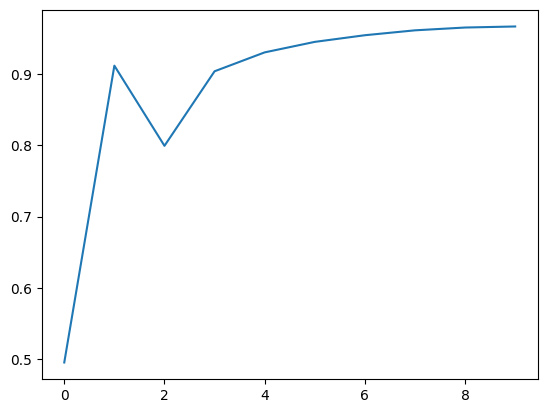

In [54]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [55]:
learn.recorder.values[-1][2]

0.9666339755058289